# 1st module

## Load the dataset

Load the dataset mat file.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sb

dataset_fname = "datasets/dataset_static.mat"

mat_contents = sio.loadmat(dataset_fname)
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'parsedData'])

The data is on the mat file variable. In this case: `parsedData`.

In [2]:
mat_var = "parsedData"

mdata = mat_contents[mat_var]
data = dict()
for col in mdata.dtype.names:
    mdata_col = mdata[col][0]
    # probe first col element to find if it's a dumb single item array (loving it)
    is_single_elem = len(mdata_col[0][0]) == 1
    data[col] = [d[0][0] if is_single_elem else d[0] for d in mdata_col]
data.keys()

dict_keys(['time', 'angle', 'step_dist', 'intensities'])

We'll build a dataframe because they're cool.

In [3]:
df = pd.DataFrame(data)
df.head()

,time,angle,step_dist,intensities
0,10.280058,180.000000,0.012531,"[0, 0, 0, 0, 43, 68, 90, 106, 111, 108, 100, 9..."
1,10.321921,181.800003,0.012531,"[0, 0, 0, 17, 51, 73, 87, 106, 116, 117, 92, 9..."
2,10.364880,183.600006,0.012531,"[0, 0, 0, 11, 43, 63, 84, 106, 119, 119, 103, ..."
3,10.408035,185.399994,0.012531,"[0, 0, 0, 0, 55, 76, 94, 108, 113, 113, 100, 1..."
4,10.451024,187.199997,0.012531,"[0, 0, 0, 15, 44, 63, 78, 102, 113, 113, 109, ..."


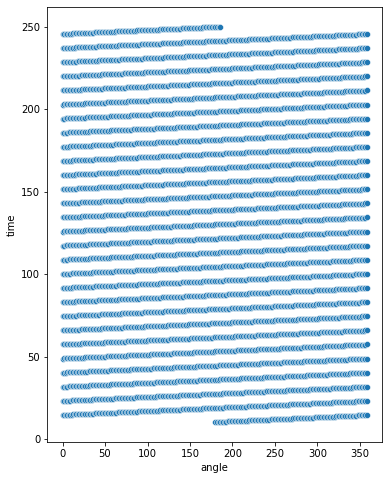

In [4]:
plt.figure(figsize=(6.0, 8.0))
sb.scatterplot(data=df, x="angle", y="time");

## Grid map

Sonar calibrated for:

- 5 meters;
- Bit length of $1.25 * 10^-2$ meters;
- Angle step of $1.8º$.

With leads to:

- $\frac{5.0}{1.25 * 10^-2} = 400$ - 400 bins per array;
- $360º / 1.8º = 200$ - 200 arrays;

In [5]:
def getScan(i):
    return df.iloc[i:i + 200]

first_scan = getScan(0)
first_scan

,time,angle,step_dist,intensities
0,10.280058,180.000000,0.012531,"[0, 0, 0, 0, 43, 68, 90, 106, 111, 108, 100, 9..."
1,10.321921,181.800003,0.012531,"[0, 0, 0, 17, 51, 73, 87, 106, 116, 117, 92, 9..."
2,10.364880,183.600006,0.012531,"[0, 0, 0, 11, 43, 63, 84, 106, 119, 119, 103, ..."
3,10.408035,185.399994,0.012531,"[0, 0, 0, 0, 55, 76, 94, 108, 113, 113, 100, 1..."
4,10.451024,187.199997,0.012531,"[0, 0, 0, 15, 44, 63, 78, 102, 113, 113, 109, ..."
...,...,...,...,...
195,18.621433,171.000000,0.012531,"[0, 0, 0, 19, 38, 68, 86, 100, 102, 92, 105, 1..."
196,18.664427,172.800003,0.012531,"[0, 0, 0, 15, 41, 65, 84, 98, 102, 94, 95, 92,..."
197,18.706421,174.600006,0.012531,"[0, 0, 0, 22, 52, 73, 89, 100, 102, 95, 100, 9..."
198,18.749483,176.399994,0.012531,"[0, 0, 22, 47, 66, 79, 97, 105, 105, 86, 79, 8..."


In [19]:
def getMinMaxIntensity(scan):
    minmax = scan["intensities"].apply(lambda row: (min(row), max(row)))
    mini = minmax[0][0]
    maxi = minmax[0][1]
    for mm in minmax:
        if mini > mm[0]:
            mini = mm[0]
        if maxi < mm[1]:
            maxi = mm[1]
    return (mini, maxi)

getMinMaxIntensity(first_scan)

(0, 191)

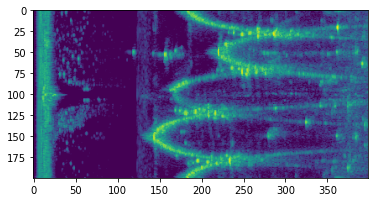

In [12]:
import matplotlib.image as mpimg
import png

def genPolarImg(scan, scale=1, outfile="polar.png"):
    img = []
    for index, scanrow in scan.iterrows():
        row = ()
        for intensity in scanrow["intensities"]:
            pixel = intensity
            row += (pixel,) * scale
        for i in range(scale):
            img.append(row)
    
    with open(outfile, "wb+") as f:
        w = png.Writer(len(img[0]), len(img), greyscale=True)
        w.write(f, img)
    plt.imshow(mpimg.imread(outfile));

genPolarImg(first_scan)

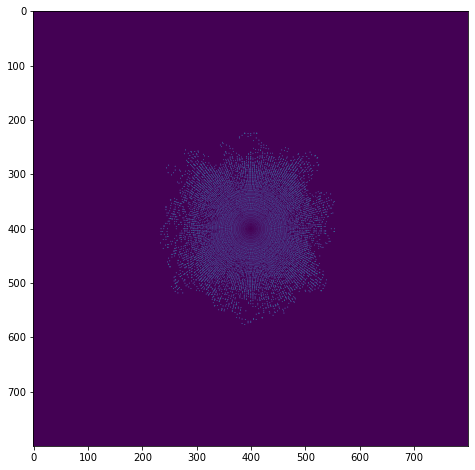

In [17]:
from math import radians, cos, sin

def genCartImg(scan, outfile="cartesian.png"):
    s = 800
    img_pre = [[(0, 0) for _ in range(s)] for _ in range(s)]
    x0 = s//2
    y0 = s//2
    
    # we need to keep count of the number of times a pixel is affected
    # and then get the mean of the values
    for index, scanrow in scan.iterrows():
        angle = radians(scanrow["angle"])
        for intensity in scanrow["intensities"]:
            x = x0 + round(intensity * cos(angle))
            y = y0 + round(intensity * sin(angle))
            pixel_info = img_pre[y][x]
            img_pre[y][x] = (pixel_info[0]+intensity, pixel_info[1]+1)
            
    img = [[0 for _ in range(s)] for _ in range(s)]
    for y in range(s):
        for x in range(s):
            pixel_info = img_pre[y][x]
            if pixel_info[1] != 0: # we only care about updated pixels
                img[y][x] = round(pixel_info[0] / pixel_info[1])
    
    with open(outfile, "wb+") as f:
        w = png.Writer(len(img[0]), len(img), greyscale=True)
        w.write(f, img)
    plt.figure(figsize=(8.0, 8.0))
    plt.imshow(mpimg.imread(outfile));

genCartImg(first_scan)